In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from Trainer import Trainer

# 資料轉換操作，將圖片數據正規化並進行標準化處理
transform = transforms.Compose([
    transforms.ToTensor(),  # 將圖片轉為張量
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 標準化
])


# CIFAR-10 類別名稱
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 載入 CIFAR-10 資料集 (訓練集與測試集)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [2]:
# 將資料加載器的輸出調整為字典格式以符合 Trainer 的需求
class DatasetWrapper(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data, label = self.dataset[idx]
        return {'input': data, 'labels': label}  # 對應Trainer的格式使用字典存放
    
# 重新包裝資料加載器
trainloader_wrapped = torch.utils.data.DataLoader(DatasetWrapper(trainset), batch_size=32, shuffle=True)
testloader_wrapped = torch.utils.data.DataLoader(DatasetWrapper(testset), batch_size=32, shuffle=False)
print(next(iter(trainloader_wrapped))['input'].shape)

torch.Size([32, 3, 32, 32])


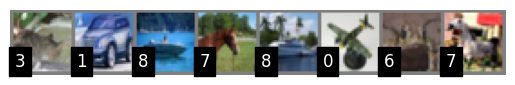

In [3]:
# 顯示圖片的工具函數
def imshow(dataloader, num_images=8):
    dataiter = iter(dataloader)
    images, labels = next(dataiter).values()  # 取得一個批次的圖片和標籤
    
    # 隨機選擇 num_images 張圖片
    selected_images = images[:num_images]
    selected_labels = labels[:num_images]

    # 把多張圖片組合成一個網格
    img_grid = torchvision.utils.make_grid(selected_images, nrow=num_images)
    
    # 反正規化
    # 由於我們設置的mean和std都是0.5，因此具體公式為`img_grid / 2 + 0.5`。
    img_grid = img_grid / 2 + 0.5
    
    # 轉換維度以適應 matplotlib 的顯示要求 (C, H, W -> H, W, C)
    npimg = img_grid.permute(1, 2, 0).numpy()

    # 顯示圖片
    plt.imshow(npimg)
    plt.axis('off')  # 隱藏座標軸

    # 設置標籤
    num_per_row = min(num_images, 8)  # 每行最多顯示8張圖片
    for i in range(num_images):
        plt.text(i * (npimg.shape[1] // num_per_row) + 5, npimg.shape[0] - 5, f'{selected_labels[i].item()}', 
                 color='white', fontsize=12, ha='center', backgroundcolor='black')

    plt.show()
imshow(trainloader_wrapped)

In [4]:
# 定義 CNN 模型
class CNNModel(nn.Module):
    def __init__(self, input_channels=3, input_shape_H=32, input_shape_W=32, output_shape = 10):
        super(CNNModel, self).__init__()
        # 第一層卷積：將輸入圖像 (batch_size, 3, 32, 32) 經過 32 個 3x3 的卷積核 (padding=1)
        # 輸出形狀為 (batch_size, 32, 32, 32)
        self.conv1 = nn.Conv2d(input_channels, 32, 3, padding=1)

        # 第二層卷積：將 (batch_size, 32, 32, 32) 經過 64 個 3x3 的卷積核 (padding=1)
        # 輸出形狀為 (batch_size, 64, 16, 16)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)

        # 最大池化層：每次將高和寬減半
        # 在第一次池化後，輸出形狀為 (batch_size, 32, 16, 16)
        # 在第二次池化後，輸出形狀為 (batch_size, 64, 8, 8)
        self.pool = nn.MaxPool2d(2, 2)

        # 計算全連接層輸入的特徵圖大小
        # conv_output_H = input_shape_H // 4 = 32 // 4 = 8
        # conv_output_W = input_shape_W // 4 = 32 // 4 = 8
        conv_output_H = input_shape_H // 4
        conv_output_W = input_shape_W // 4

        # 全連接層1：輸入來自卷積層的展平結果，4096 = 64 * 8 * 8
        # 輸出 256 維度，輸入形狀 (batch_size, 4096)，輸出形狀 (batch_size, 256)
        self.fc1 = nn.Linear(64 * conv_output_H * conv_output_W, 256)

        # 全連接層2：輸入 256 維度，輸出 64 維度，輸出形狀 (batch_size, 64)
        self.fc2 = nn.Linear(256, 64)

        # 全連接層3：輸入 64 維度，輸出 output_shape 維度，對應 output_shape 個類別
        # 輸出形狀為 (batch_size, output_shape)
        self.fc3 = nn.Linear(64, output_shape)

        self.criterion = nn.CrossEntropyLoss()

    def forward(self, input, labels):
        # 第一層卷積 + 池化：將輸入 (batch_size, 3, 32, 32) -> (batch_size, 32, 16, 16)
        x = self.pool(torch.relu(self.conv1(input)))

        # 第二層卷積 + 池化：將輸入 (batch_size, 32, 16, 16) -> (batch_size, 64, 8, 8)
        x = self.pool(torch.relu(self.conv2(x)))

        # 展平：將輸入 (batch_size, 64, 8, 8) 展平成 (batch_size, 4096)
        x = x.view(x.size(0), -1)

        # 全連接層1：輸入 (batch_size, 4096) -> (batch_size, 256)
        x = torch.relu(self.fc1(x))

        # 全連接層2：輸入 (batch_size, 256) -> (batch_size, 64)
        x = torch.relu(self.fc2(x))

        # 全連接層3：輸入 (batch_size, 64) -> (batch_size, 10)
        x = self.fc3(x)

        return self.criterion(x, labels), x # 回傳Loss與前向傳播結果。
        
model = CNNModel()

In [ ]:
# 定義損失函數和優化器
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 建立 Trainer 實例並開始訓練
trainer = Trainer(
    epochs=10,
    train_loader=trainloader_wrapped,
    valid_loader=testloader_wrapped,
    model=model,
    optimizer=[optimizer],          # 當初設計的時候有考慮多的優化器，因此要用容器型態
)
# 開始訓練
trainer.train(show_loss=True)

Valid Epoch 0: 100%|██████████| 313/313 [00:02<00:00, 127.62it/s, loss=0.915]


Saving Model With Loss 1.02711
Train Loss: 1.33959| Valid Loss: 1.02711| Best Loss: 1.02711



Train Epoch 1:  22%|██▏       | 340/1563 [00:03<00:12, 97.15it/s, loss=0.677]